In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import  DataLoader
import torch.optim as optim
import torch.mps

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# **CONFIG** and List of General Changes:
1. Changed Batch Size to 32
2. Used Adam Optimizer
3. Set all Augments to true
4. Used mps to utilize Apple Silicon Chip

In [50]:
# GPU
device = ('mps' if torch.mps.is_available() else 'cpu')
torch.mps.empty_cache()
torch.mps.PYTORCH_MPS_HIGH_WATERMARK_RATIO = 0.0
# Transform (data augmentation) configuration values
IMAGE_SIZE = 227
resize_params=(IMAGE_SIZE, IMAGE_SIZE)
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
random_rotation_params=20
random_flip_params=0.1
color_jitter_params={"brightness": 0.1, "contrast": 0.1, "saturation": 0.1}
random_sharpness_params={"sharpness_factor": 2, "p": 0.1}
normalize_params={"mean": mean, "std": std}
random_erasing_params={"p": 0.75, "scale": (0.02, 0.1), "value": 1.0}
transform_config = {'resize':True, #doing all augments
                  'random_rotation':True, 
                  'random_flip':True, 
                  'color_jitter':True, 
                  'random_sharpness':True, 
                  'normalize':True, 
                  'random_erasing':True}
# hyper-parameters (for generalization, not for tuning)
random_seed = 42
# hyper-parameters (that should be tuned)
batch_size = 32
print(device)





mps


In [51]:
# reset random for reproducibility (change mps to cuda if non mac)
def reset_random(random_seed):
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
  torch.backends.mps.deterministic = True
  torch.backends.mps.benchmark = False
  np.random.seed(random_seed)
  random.seed(random_seed)

reset_random(random_seed)

In [52]:
# Function to dynamically create transforms
def build_transforms(
    resize=True,
    random_rotation=False,
    random_flip=False,
    color_jitter=False,
    random_sharpness=False,
    normalize=True,
    random_erasing=False,
):
    """
    Dynamically builds a transform pipeline based on user arguments.
    """
    transform_list = []

    if resize:
        transform_list.append(transforms.Resize(resize_params))  # Resize the image
    if random_rotation:
        transform_list.append(transforms.RandomRotation(random_rotation_params))  # Rotate the image
    if random_flip:
        transform_list.append(transforms.RandomHorizontalFlip(random_flip_params))  # Flip the image
    if color_jitter:
        transform_list.append(transforms.ColorJitter(**color_jitter_params))  # Adjust brightness, contrast, etc.
    if random_sharpness:
        transform_list.append(transforms.RandomAdjustSharpness(**random_sharpness_params))  # Adjust sharpness
    # ToTensor is essential
    transform_list.append(transforms.ToTensor())  # Convert to PyTorch tensor
    if normalize:
        transform_list.append(transforms.Normalize(**normalize_params))  # Normalize the image
    if random_erasing:
        transform_list.append(transforms.RandomErasing(**random_erasing_params))  # Erase random patches

    return transforms.Compose(transform_list)

In [53]:
def load_data(data_dir='./Cifar10', transform_config=None, non_transform_config = {'resize': True,
                                                                               'random_rotation': False,
                                                                                'random_flip': False,
                                                                                'color_jitter': False,
                                                                                'random_sharpness': False,
                                                                                'normalize': True,
                                                                                'random_erasing': False}):
    
    if transform_config is None:
        print("Note: Users didn't configure transform_config. Using default configuration.")
        
    transform = build_transforms(**transform_config)
    non_transform = build_transforms(**non_transform_config)
    
    train_val_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=None
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=non_transform
    )
    
    # split
    train_indices, val_indices = train_test_split(
        range(len(train_val_dataset)), test_size=0.2, random_state=random_seed
    )
    train_dataset = torch.utils.data.Subset(train_val_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(train_val_dataset, val_indices)
    # apply transform
    train_dataset.dataset.transform = transform
    val_dataset.dataset.transform = non_transform

    return train_dataset, val_dataset, test_dataset

def get_dataloader(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [54]:
train, dev, test = load_data(transform_config=transform_config)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
train_loader = get_dataloader(train)
dev_loader = get_dataloader(dev, shuffle=False)
test_loader = get_dataloader(test, shuffle=False)

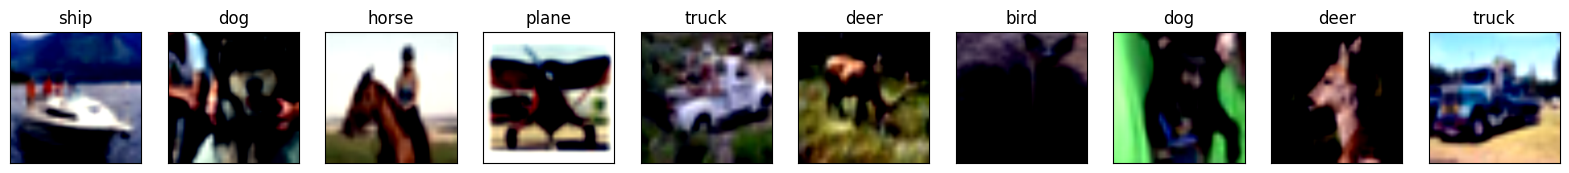

In [56]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

# Display an overview of data
def overview_data(loader, classes, num_images=5):
    data_iterable = iter(loader)  # Convert the loader to an iterable
    images, labels = next(data_iterable)  # Get the first batch

    num_images = min(num_images, len(images))  # Limit to the batch size
    fig = plt.figure(figsize=(20, 10))  # Create figure

    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])  # Add subplot
        plt.imshow(im_convert(images[idx]))  # Convert and display image
        ax.set_title(classes[labels[idx].item()])  # Set title

    plt.show()  # Display the figure

# Preview some data
overview_data(train_loader, classes, num_images=10)

In [57]:
class AlexNet(nn.Module): #Baseline AlexNet
  def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

# SuperAlexNet is an architecture with the following changes:
1. Changed kernel size to 7 and stride to 2 in layer 1.
2. Used Parametric ReLU (PReLU), which is an activation function that generalizes the traditional rectified unit with a slope for negative values.
3. Added another layer (layer 6).
4. Changed Max Pool to Avg Pool in deeper layers.


In [67]:
class SuperAlexNet(nn.Module): #
  def __init__(self, num_classes=10):
        super(SuperAlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(96),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.PReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.PReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.AvgPool2d(kernel_size = 3, stride = 2))
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.PReLU(),
            nn.AvgPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(3456, 4096),
            nn.PReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.PReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
  def forward(self, x):
    
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [59]:
def train_model(
    model, 
    train_loader, 
    dev_loader, 
    num_epochs=20, 
    learning_rate=0.005, 
    weight_decay=0.005, 
    momentum=0.9, 
    save_path="best_model.pth",
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_val_acc = 0.0  # Best validation accuracy for saving model

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Metrics calculation
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description
            train_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

        # Training confusion matrix and report
        cm_train = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nTraining Confusion Matrix:")
        print(cm_train)

        if classes:
            print("\nTraining Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        val_bar = tqdm(dev_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Metrics calculation
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update tqdm description
                val_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dev_loader)
        epoch_acc = 100 * correct / total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%")

        # Validation confusion matrix and report
        cm_val = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nValidation Confusion Matrix:")
        print(cm_val)

        if classes:
            print("\nValidation Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Save the best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path} with Val Accuracy: {epoch_acc:.2f}%")

    print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.2f}%")
    return train_loss, val_loss, train_acc, val_acc


In [60]:
def get_model(model_type="alexnet", num_classes=10):
    """
    Returns a model based on the specified model type.
    
    Parameters:
    - model_type: str, either "alexnet" or "alexnet_skip".
    - num_classes: int, the number of output classes.
    
    Returns:
    - nn.Module: PyTorch model instance.
    """
    if model_type == "alexnet":
        return AlexNet(num_classes=num_classes)
    elif model_type =="SuperAlexNet":
        return SuperAlexNet(num_classes = num_classes)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Choose 'alexnet' or 'alexnet_skip'.")


# Choose the model type
model_type = "SuperAlexNet"  # Change this to "alexnet" or "alexnet_skip" as needed

# Dynamically get the model
model = get_model(model_type=model_type, num_classes=num_classes)


# Train and validate
train_loss, val_loss, train_acc, val_acc = train_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    num_epochs=20,
    learning_rate=0.0001,
    weight_decay=0.0001,
    momentum=0.5,
    save_path="best_model.pth"
)


Epoch 1/20


Train Loss: 1.3350, Train Accuracy: 51.98%

Training Confusion Matrix:
[[2167  225  281  115   99   66   57  109  678  230]
 [ 200 2628   38   51   37   39   78   68  246  636]
 [ 349   59 1496  314  601  345  324  257  160   65]
 [ 122   85  347 1356  294  861  417  234  130  131]
 [ 175   56  562  282 1711  226  451  477   66   61]
 [  67   53  321  749  277 1770  212  386   65   85]
 [  38   71  243  357  393  153 2456  111   58  124]
 [  66   59  205  229  396  393  128 2307   59  164]
 [ 593  285  134   80   41   47   48   41 2504  210]
 [ 212  675   58   98   28   46  115  127  204 2397]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.54      0.54      0.54      4027
         car       0.63      0.65      0.64      4021
        bird       0.41      0.38      0.39      3970
         cat       0.37      0.34      0.36      3977
        deer       0.44      0.42      0.43      4067
         dog       0.45      0.44      0

Val Loss: 1.1303, Val Accuracy: 59.59%

Validation Confusion Matrix:
[[553   8  35  12  26   1  12  27 147 152]
 [ 22 464   1   4   6   0  30   5  34 413]
 [ 77   8 403  70  76  42 193  78  42  41]
 [ 34   5  51 313  61 150 208  93  37  71]
 [ 25   3  73  32 411  13 193 141  16  26]
 [ 11   4  55 136  33 438  93 186  17  42]
 [  5   2  20  30  17   6 873   6  14  23]
 [ 16   6  20  23  43  21  29 746  17  73]
 [ 44  16   8  11   6   2  14   3 816  97]
 [ 12  21   5   2   3   2  15   7  31 942]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.69      0.57      0.62       973
         car       0.86      0.47      0.61       979
        bird       0.60      0.39      0.47      1030
         cat       0.49      0.31      0.38      1023
        deer       0.60      0.44      0.51       933
         dog       0.65      0.43      0.52      1015
        frog       0.53      0.88      0.66       996
       horse       0.58      0.7

Train Loss: 0.9738, Train Accuracy: 65.36%

Training Confusion Matrix:
[[2703  126  277   85   98   47   32   90  408  161]
 [ 121 3209   28   29   18   17   32   33  147  387]
 [ 303   39 1999  272  475  268  299  169  104   42]
 [  96   38  301 1764  281  775  346  199   96   81]
 [ 133   35  368  248 2407  160  275  365   43   33]
 [  46   29  253  719  239 2212  170  257   24   36]
 [  36   34  229  284  267  121 2902   45   51   35]
 [  65   29  177  168  293  295   31 2848   24   76]
 [ 359  163   71   75   32   26   40   25 3078  114]
 [ 148  425   24   68   34   24   42   55  117 3023]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.67      0.67      0.67      4027
         car       0.78      0.80      0.79      4021
        bird       0.54      0.50      0.52      3970
         cat       0.48      0.44      0.46      3977
        deer       0.58      0.59      0.59      4067
         dog       0.56      0.56      0

Val Loss: 0.8251, Val Accuracy: 70.99%

Validation Confusion Matrix:
[[791  15  60  13  17   0   2   5  40  30]
 [ 35 828   6   5   4   1   2   2  38  58]
 [106   5 702  67  56  19  36  21  12   6]
 [ 31   6 114 634  77  64  40  26  19  12]
 [ 30   3 106  46 640  12  42  41  11   2]
 [ 13   1  97 339  60 420  21  52   7   5]
 [ 18   4  90  71  42  15 735   3  15   3]
 [ 26   5  72  66  94  25   4 678   8  16]
 [108  20  22   5   4   2   1   3 840  12]
 [ 43  75  11  10  10   0   5   9  46 831]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.66      0.81      0.73       973
         car       0.86      0.85      0.85       979
        bird       0.55      0.68      0.61      1030
         cat       0.50      0.62      0.56      1023
        deer       0.64      0.69      0.66       933
         dog       0.75      0.41      0.53      1015
        frog       0.83      0.74      0.78       996
       horse       0.81      0.6

Train Loss: 0.8219, Train Accuracy: 70.64%

Training Confusion Matrix:
[[2940  112  236   87   98   21   29   55  296  153]
 [ 109 3354   24   23   15   12   38   27  100  319]
 [ 297   22 2342  232  371  196  255  140   84   31]
 [  83   35  247 1983  284  771  272  161   82   59]
 [ 111   19  318  261 2653  115  208  316   42   24]
 [  36    7  211  709  222 2388  125  242   16   29]
 [  27   28  205  232  195   99 3112   38   41   27]
 [  57   19  140  158  258  225   29 3054   20   46]
 [ 285  123   63   54   34   18   29   12 3273   92]
 [ 127  354   25   57   23   20   18   55  123 3158]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.72      0.73      0.73      4027
         car       0.82      0.83      0.83      4021
        bird       0.61      0.59      0.60      3970
         cat       0.52      0.50      0.51      3977
        deer       0.64      0.65      0.65      4067
         dog       0.62      0.60      0

Val Loss: 0.7511, Val Accuracy: 73.53%

Validation Confusion Matrix:
[[712  13  50  31  43   1  11   7  86  19]
 [ 28 824   5  15   5   1   7   1  54  39]
 [ 60   3 688  69 105  30  42  20  12   1]
 [  8   2  82 664  95  86  61  15   6   4]
 [ 11   0  50  39 750   9  33  30  11   0]
 [  2   1  56 281 106 505  25  32   2   5]
 [  1   1  62  77  48   3 796   1   5   2]
 [ 17   1  33  63 118  47   2 700   7   6]
 [ 44  10  14  28   5   1   6   2 900   7]
 [ 45  52   9  18  13   1   9   3  76 814]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.77      0.73      0.75       973
         car       0.91      0.84      0.87       979
        bird       0.66      0.67      0.66      1030
         cat       0.52      0.65      0.58      1023
        deer       0.58      0.80      0.68       933
         dog       0.74      0.50      0.59      1015
        frog       0.80      0.80      0.80       996
       horse       0.86      0.7

Train Loss: 0.7165, Train Accuracy: 74.75%

Training Confusion Matrix:
[[3102   87  205   71   76   35   22   59  252  118]
 [  86 3495   16   23    5   13   27   14   87  255]
 [ 248   21 2526  197  344  172  223  138   67   34]
 [  69   16  244 2226  249  675  240  144   58   56]
 [  85    5  244  214 2922  118  190  234   36   19]
 [  38   15  187  665  200 2515  116  216   16   17]
 [  26   23  178  226  159   93 3218   29   29   23]
 [  48   15  114  145  237  193   15 3173   22   44]
 [ 235  102   45   53   30   12   23    5 3391   87]
 [ 131  253   21   45   14   17   29   34   83 3333]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.76      0.77      0.77      4027
         car       0.87      0.87      0.87      4021
        bird       0.67      0.64      0.65      3970
         cat       0.58      0.56      0.57      3977
        deer       0.69      0.72      0.70      4067
         dog       0.65      0.63      0

Val Loss: 0.6745, Val Accuracy: 76.40%

Validation Confusion Matrix:
[[726  17  79  32  12   4   6   1  70  26]
 [  7 895  11  12   1   3   2   0  22  26]
 [ 49   2 761  50  78  33  43   6   6   2]
 [  9   1  89 711  37 119  39  12   3   3]
 [ 15   0  55  62 702  13  34  39  10   3]
 [  4   0  72 239  50 608   8  28   2   4]
 [  4   2  49  89  25  22 794   4   5   2]
 [ 15   1  65  71  68  49   4 710   2   9]
 [ 50  19  24  12   2   2   7   1 889  11]
 [ 27  93  14  24   2   4   4   3  25 844]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.80      0.75      0.77       973
         car       0.87      0.91      0.89       979
        bird       0.62      0.74      0.68      1030
         cat       0.55      0.70      0.61      1023
        deer       0.72      0.75      0.74       933
         dog       0.71      0.60      0.65      1015
        frog       0.84      0.80      0.82       996
       horse       0.88      0.7

Train Loss: 0.6301, Train Accuracy: 77.60%

Training Confusion Matrix:
[[3215   60  197   65   63   21   19   44  224  119]
 [  62 3592   20   12    4   10   25   13   82  201]
 [ 251   13 2704  181  299  149  190  107   56   20]
 [  74   16  202 2407  222  624  206  129   54   43]
 [  82    9  232  194 3062  123  128  205   20   12]
 [  27    3  172  639  190 2630  110  184   15   15]
 [  27   28  182  190  138   81 3289   25   28   16]
 [  35   15  125  139  197  170   19 3267   10   29]
 [ 210   88   42   36   12   10   30   15 3463   77]
 [ 117  232   19   44    7   18   22   28   63 3410]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.78      0.80      0.79      4027
         car       0.89      0.89      0.89      4021
        bird       0.69      0.68      0.69      3970
         cat       0.62      0.61      0.61      3977
        deer       0.73      0.75      0.74      4067
         dog       0.69      0.66      0

Val Loss: 0.6171, Val Accuracy: 78.50%

Validation Confusion Matrix:
[[702  36  60  17   7  13   7   9  81  41]
 [  8 904   6   2   2   4   1   1  11  40]
 [ 60   6 718  52  46  53  39  45   6   5]
 [ 17   1  65 545  43 258  34  52   4   4]
 [ 14   1  42  28 721  33  23  62   7   2]
 [  3   4  30  88  32 784  12  59   1   2]
 [  4   2  63  44  28  21 821   7   3   3]
 [  4   0  21  22  52  47   3 839   3   3]
 [ 26  19  21  14   2  13   3   4 888  27]
 [  7  62   6   6   2   6   5   7  11 928]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.83      0.72      0.77       973
         car       0.87      0.92      0.90       979
        bird       0.70      0.70      0.70      1030
         cat       0.67      0.53      0.59      1023
        deer       0.77      0.77      0.77       933
         dog       0.64      0.77      0.70      1015
        frog       0.87      0.82      0.84       996
       horse       0.77      0.8

Train Loss: 0.5566, Train Accuracy: 80.62%

Training Confusion Matrix:
[[3313   66  183   55   52   23   22   37  176  100]
 [  51 3648   14   13    6    9   23    7   58  192]
 [ 199   14 2883  166  243  140  195   76   39   15]
 [  86   16  170 2596  192  544  180  118   45   30]
 [  65    3  189  172 3179   97  120  203   25   14]
 [  26   11  138  576  149 2791   86  180   12   16]
 [  30   18  159  165  106   76 3388   18   29   15]
 [  39   15   92  111  162  171   20 3365   12   19]
 [ 174   64   33   35   24   11   23    5 3559   55]
 [  94  182   10   30   12   11   17   19   59 3526]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.82      0.82      4027
         car       0.90      0.91      0.91      4021
        bird       0.74      0.73      0.74      3970
         cat       0.66      0.65      0.66      3977
        deer       0.77      0.78      0.78      4067
         dog       0.72      0.70      0

Val Loss: 0.6041, Val Accuracy: 79.33%

Validation Confusion Matrix:
[[874   8  21  17  13   8   2   6  17   7]
 [ 25 932   1   6   0   0   0   0  11   4]
 [ 73   2 680  58  89  30  64  26   4   4]
 [ 15   2  34 721  60 104  55  26   4   2]
 [ 18   2  16  45 775   3  49  16   8   1]
 [  6   3  26 189  55 652  32  50   0   2]
 [  5   2  22  41  12   8 897   3   5   1]
 [ 12   2  17  36  79  24   5 813   4   2]
 [ 82  24   9   7   5   0   1   4 869  16]
 [ 66 209   4   9   2   1   3  10  16 720]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.74      0.90      0.81       973
         car       0.79      0.95      0.86       979
        bird       0.82      0.66      0.73      1030
         cat       0.64      0.70      0.67      1023
        deer       0.71      0.83      0.77       933
         dog       0.79      0.64      0.71      1015
        frog       0.81      0.90      0.85       996
       horse       0.85      0.8

Train Loss: 0.4805, Train Accuracy: 82.92%

Training Confusion Matrix:
[[3422   46  125   66   45   17   20   30  174   82]
 [  44 3702    9   11    2    8   16    6   57  166]
 [ 171   10 3018  149  224  111  174   67   30   16]
 [  72    9  164 2712  174  508  163  111   31   33]
 [  47    4  180  140 3309   91  104  164   15   13]
 [  26    4  116  533  134 2911   82  153   12   14]
 [  22   19  147  158   85   60 3470   14   19   10]
 [  26    6   74  126  144  135   17 3445    9   24]
 [ 166   52   31   29   17    7   13    6 3610   52]
 [  78  156   17   32    7   12   13   24   51 3570]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.84      0.85      0.84      4027
         car       0.92      0.92      0.92      4021
        bird       0.78      0.76      0.77      3970
         cat       0.69      0.68      0.68      3977
        deer       0.80      0.81      0.81      4067
         dog       0.75      0.73      0

Val Loss: 0.5728, Val Accuracy: 80.55%

Validation Confusion Matrix:
[[784  12  67   9  15  13   5  26  29  13]
 [  9 901   6   2   2   5   0   9   7  38]
 [ 38   2 783  22  34  60  58  27   5   1]
 [ 17   3  67 506  23 305  52  43   4   3]
 [  7   0  50  24 684  47  64  51   6   0]
 [  4   2  38  61  16 830  21  42   0   1]
 [  6   1  34  26   8  25 891   0   4   1]
 [  4   1  29  20  23  51   5 858   3   0]
 [ 40  21  14   6   1  10   2   8 896  19]
 [ 24  33   8   9   0   5   2  29   8 922]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.84      0.81      0.82       973
         car       0.92      0.92      0.92       979
        bird       0.71      0.76      0.74      1030
         cat       0.74      0.49      0.59      1023
        deer       0.85      0.73      0.79       933
         dog       0.61      0.82      0.70      1015
        frog       0.81      0.89      0.85       996
       horse       0.78      0.8

Train Loss: 0.4269, Train Accuracy: 85.05%

Training Confusion Matrix:
[[3533   33  110   43   41   20   15   31  141   60]
 [  34 3769    4    8    4    3   17    6   48  128]
 [ 161    9 3162  132  170   96  145   48   33   14]
 [  63    5  146 2826  170  469  148   81   38   31]
 [  59    4  154  147 3377   86   97  125   12    6]
 [  27    6  107  494  117 3023   62  128   11   10]
 [  18   12  128  146   84   44 3524   17   19   12]
 [  30    4   65   99  127  122   13 3518    7   21]
 [ 138   54   23   26   13    7   28    6 3643   45]
 [  63  138   10   18    7    4    8   18   50 3644]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.86      0.88      0.87      4027
         car       0.93      0.94      0.94      4021
        bird       0.81      0.80      0.80      3970
         cat       0.72      0.71      0.71      3977
        deer       0.82      0.83      0.83      4067
         dog       0.78      0.76      0

Val Loss: 0.5201, Val Accuracy: 82.59%

Validation Confusion Matrix:
[[835  10  62   9   3   0   3   0  42   9]
 [ 12 914   5   1   0   0   1   0  19  27]
 [ 42   1 879  28  24  10  31   5  10   0]
 [ 32   6  82 709  33  79  57  11   5   9]
 [ 12   0  81  29 748  14  27  10   9   3]
 [  6   5  65 177  38 659  22  27   9   7]
 [  7   1  50  18  10   6 894   0   6   4]
 [ 19   2  54  28  79  25  10 762   5  10]
 [ 39   2  17   2   1   1   1   2 940  12]
 [ 30  48   4   6   0   1   4   1  27 919]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.86      0.83       973
         car       0.92      0.93      0.93       979
        bird       0.68      0.85      0.75      1030
         cat       0.70      0.69      0.70      1023
        deer       0.80      0.80      0.80       933
         dog       0.83      0.65      0.73      1015
        frog       0.85      0.90      0.87       996
       horse       0.93      0.7

Train Loss: 0.3719, Train Accuracy: 86.92%

Training Confusion Matrix:
[[3585   30   97   45   35   17    9   23  134   52]
 [  21 3778    8   18    2    6   15    3   40  130]
 [ 129    4 3261  101  161  110  126   44   22   12]
 [  55   12  123 2971  117  434  132   84   27   22]
 [  45    1  144  121 3468   69   78  126    8    7]
 [  20    4  107  438   93 3148   47  111    8    9]
 [  18    9  116  136   69   40 3585    9   17    5]
 [  23    4   56   83  124   91   12 3599    6    8]
 [ 133   39   15   20   12    3   18    8 3706   29]
 [  53  135   12   28    8   10    6   10   30 3668]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.88      0.89      0.88      4027
         car       0.94      0.94      0.94      4021
        bird       0.83      0.82      0.82      3970
         cat       0.75      0.75      0.75      3977
        deer       0.85      0.85      0.85      4067
         dog       0.80      0.79      0

Val Loss: 0.5092, Val Accuracy: 82.46%

Validation Confusion Matrix:
[[799   9  14  17  11  16   7   4  41  55]
 [  7 832   1   2   0   3   2   0  32 100]
 [ 58   0 731  37  46  82  50  20   4   2]
 [ 19   1  32 604  33 286  23  18   2   5]
 [  9   2  21  26 779  39  17  28   8   4]
 [  3   1  17  67  28 859   4  31   0   5]
 [  6   0  36  40  16  34 858   1   3   2]
 [  8   0   6  26  36  51   4 852   3   8]
 [ 20   2   5   7   0  11   1   1 947  23]
 [  5  15   2   7   0   1   4   7  14 985]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.86      0.82      0.84       973
         car       0.97      0.85      0.90       979
        bird       0.85      0.71      0.77      1030
         cat       0.73      0.59      0.65      1023
        deer       0.82      0.83      0.83       933
         dog       0.62      0.85      0.72      1015
        frog       0.88      0.86      0.87       996
       horse       0.89      0.8

Train Loss: 0.3184, Train Accuracy: 88.69%

Training Confusion Matrix:
[[3648   21   99   43   25   17    9   16   97   52]
 [  20 3834    6    8    3    4   11    4   36   95]
 [ 129    6 3342   83  119   91  121   53   21    5]
 [  53    7  100 3058  137  395  125   64   19   19]
 [  37    4  118  125 3545   67   61   98    8    4]
 [  17    5   89  385   79 3259   47   89    8    7]
 [  11    7  101   95   60   45 3647   15   15    8]
 [  19    1   48   85   89   71   10 3666    6   11]
 [ 103   35   18   14    3    8    3    5 3765   29]
 [  45  109    6   14    7    5    9   16   38 3711]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.89      0.91      0.90      4027
         car       0.95      0.95      0.95      4021
        bird       0.85      0.84      0.85      3970
         cat       0.78      0.77      0.78      3977
        deer       0.87      0.87      0.87      4067
         dog       0.82      0.82      0

Val Loss: 0.4513, Val Accuracy: 85.25%

Validation Confusion Matrix:
[[824  12  33  18   9   2  10   3  42  20]
 [  5 910   5   4   3   4   0   1   9  38]
 [ 45   2 823  56  32  22  34  13   3   0]
 [ 16   1  49 785  22  94  29  23   3   1]
 [  9   0  36  40 782  10  16  33   7   0]
 [  2   0  35 157  27 731   9  50   0   4]
 [  7   1  36  38  11  15 883   0   4   1]
 [  8   0  31  28  26  17   4 873   2   5]
 [ 23   7   8   8   1   0   4   3 948  15]
 [ 11  25   8   7   0   2   1   9  11 966]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.85      0.86       973
         car       0.95      0.93      0.94       979
        bird       0.77      0.80      0.79      1030
         cat       0.69      0.77      0.73      1023
        deer       0.86      0.84      0.85       933
         dog       0.81      0.72      0.76      1015
        frog       0.89      0.89      0.89       996
       horse       0.87      0.8

Train Loss: 0.2839, Train Accuracy: 89.87%

Training Confusion Matrix:
[[3705   19   83   39   22   13   10   13   84   39]
 [  26 3831    4    9    2    5    9    5   31   99]
 [ 117    8 3401   92  112   73  103   39   18    7]
 [  40    4   85 3185  111  348  108   61   22   13]
 [  30    2  107   93 3612   66   47   97    8    5]
 [  16    7   75  350   81 3308   41   93    6    8]
 [  10    8   99   77   50   34 3696   10   14    6]
 [  21    2   40   75   92   78    8 3677    5    8]
 [  77   34   17   15   13    3    9    3 3778   34]
 [  47   93    7    9    4    4    7    9   26 3754]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.91      0.92      0.91      4027
         car       0.96      0.95      0.95      4021
        bird       0.87      0.86      0.86      3970
         cat       0.81      0.80      0.80      3977
        deer       0.88      0.89      0.88      4067
         dog       0.84      0.83      0

Val Loss: 0.4825, Val Accuracy: 84.99%

Validation Confusion Matrix:
[[832  10  25  22   7   5   0  24  34  14]
 [  6 924   2   4   1   1   0   5  13  23]
 [ 40   3 793  38  54  43  22  34   3   0]
 [ 12   2  36 730  38 156  11  33   4   1]
 [ 12   0  23  22 815  20   3  32   5   1]
 [  1   0  20  92  35 810   2  54   0   1]
 [  8   1  38  70  44  20 808   3   2   2]
 [  3   0  12  20  35  26   2 892   1   3]
 [ 31   6  12   5   1   3   0   4 950   5]
 [ 17  24   5   8   2   3   1  13  22 945]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.86      0.86      0.86       973
         car       0.95      0.94      0.95       979
        bird       0.82      0.77      0.79      1030
         cat       0.72      0.71      0.72      1023
        deer       0.79      0.87      0.83       933
         dog       0.75      0.80      0.77      1015
        frog       0.95      0.81      0.88       996
       horse       0.82      0.9

Train Loss: 0.2466, Train Accuracy: 91.20%

Training Confusion Matrix:
[[3736   15   87   39   18    5   18    8   78   23]
 [  19 3872    7    5    1    3    4    6   25   79]
 [ 111    3 3480   77   91   73   79   38   15    3]
 [  37    3   91 3263   94  304   90   60   16   19]
 [  18    0   92   78 3693   57   46   70    6    7]
 [  13    2   70  322   70 3399   33   65    5    6]
 [  17    9   77   73   45   22 3739    7   11    4]
 [   8    1   41   62   87   63    8 3720    5   11]
 [  68   31   10   10    6    8   10    6 3806   28]
 [  32   90    5   15    1    5    6    6   27 3773]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.92      0.93      0.92      4027
         car       0.96      0.96      0.96      4021
        bird       0.88      0.88      0.88      3970
         cat       0.83      0.82      0.82      3977
        deer       0.90      0.91      0.90      4067
         dog       0.86      0.85      0

Val Loss: 0.4474, Val Accuracy: 85.88%

Validation Confusion Matrix:
[[874  17  13   7   4   4   1   3  37  13]
 [  7 921   2   3   0   0   1   1  11  33]
 [ 70   1 817  27  32  30  30  16   4   3]
 [ 34   4  42 693  41 141  33  22   7   6]
 [ 16   1  26  22 805  16   8  30   5   4]
 [  8   1  23  87  31 815   9  35   1   5]
 [ 16   0  33  20  21  11 888   0   5   2]
 [ 12   0  16  23  32  16   4 882   4   5]
 [ 34  14   5   2   2   1   2   2 942  13]
 [ 26  47   4   1   0   1   1   0   9 951]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.80      0.90      0.84       973
         car       0.92      0.94      0.93       979
        bird       0.83      0.79      0.81      1030
         cat       0.78      0.68      0.73      1023
        deer       0.83      0.86      0.85       933
         dog       0.79      0.80      0.80      1015
        frog       0.91      0.89      0.90       996
       horse       0.89      0.8

Train Loss: 0.2164, Train Accuracy: 92.36%

Training Confusion Matrix:
[[3788   10   60   30   21   11    5   11   62   29]
 [  16 3878    2    8    0    3    6    2   27   79]
 [  95    3 3567   55   88   61   60   25   13    3]
 [  33    6   85 3349   95  261   81   38   13   16]
 [  17    4   79   83 3713   53   39   67    8    4]
 [  13    1   45  266   57 3497   34   68    2    2]
 [   6    9   65   72   47   21 3757    6   15    6]
 [  12    2   32   61   61   50    5 3767    7    9]
 [  59   23   17   11    7    6   12    1 3834   13]
 [  28   76    8   10    7    5    5   11   17 3793]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.93      0.94      0.94      4027
         car       0.97      0.96      0.97      4021
        bird       0.90      0.90      0.90      3970
         cat       0.85      0.84      0.85      3977
        deer       0.91      0.91      0.91      4067
         dog       0.88      0.88      0

Val Loss: 0.4992, Val Accuracy: 84.67%

Validation Confusion Matrix:
[[904  20   4   5   5   2   3   2  15  13]
 [  7 937   0   2   1   0   0   1   7  24]
 [111   9 732  44  29  21  59  17   4   4]
 [ 58   9  34 740  24  75  38  33   7   5]
 [ 23   1  28  24 779   9  16  46   6   1]
 [ 16   4  27 136  36 723  16  51   4   2]
 [ 18   7  12  25  16   9 900   2   4   3]
 [ 19   2  14  23  20  11   5 890   4   6]
 [ 59  15   3   4   2   2   4   3 911  14]
 [ 14  49   4   2   2   1   1   5  11 951]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.74      0.93      0.82       973
         car       0.89      0.96      0.92       979
        bird       0.85      0.71      0.78      1030
         cat       0.74      0.72      0.73      1023
        deer       0.85      0.83      0.84       933
         dog       0.85      0.71      0.77      1015
        frog       0.86      0.90      0.88       996
       horse       0.85      0.9

Train Loss: 0.1891, Train Accuracy: 93.36%

Training Confusion Matrix:
[[3810    8   66   20   14    8   10   11   53   27]
 [  23 3896    2    4    1    2    7    2   17   67]
 [  81    6 3582   64   81   48   64   23   16    5]
 [  38    4   63 3462   78  223   53   28   13   15]
 [  19    0   68   69 3767   37   35   65    2    5]
 [   8    2   44  244   38 3561   27   55    4    2]
 [  13    4   62   63   36   18 3791    2   11    4]
 [   7    3   26   44   54   53    5 3808    1    5]
 [  58   19    5   14    8    1   13    2 3849   14]
 [  29   65    5    7    4    6    4    5   16 3819]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.93      0.95      0.94      4027
         car       0.97      0.97      0.97      4021
        bird       0.91      0.90      0.91      3970
         cat       0.87      0.87      0.87      3977
        deer       0.92      0.93      0.92      4067
         dog       0.90      0.89      0

Val Loss: 0.4222, Val Accuracy: 86.47%

Validation Confusion Matrix:
[[881  20  21   4   5   1   2   1  25  13]
 [  7 931   0   5   1   0   0   0   7  28]
 [ 62   3 823  40  18  19  46   9   4   6]
 [ 39   7  38 763  20  77  45  19   5  10]
 [ 11   0  41  26 790  15  16  23   6   5]
 [  7   4  22 141  23 755  25  30   3   5]
 [ 14   2  23  12   6   8 926   1   3   1]
 [  6   0  14  23  31  33   4 869   2  12]
 [ 40  16   1   2   1   2   3   1 932  19]
 [ 13  36   2   1   1   1   1   2   6 977]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.82      0.91      0.86       973
         car       0.91      0.95      0.93       979
        bird       0.84      0.80      0.82      1030
         cat       0.75      0.75      0.75      1023
        deer       0.88      0.85      0.86       933
         dog       0.83      0.74      0.78      1015
        frog       0.87      0.93      0.90       996
       horse       0.91      0.8

Train Loss: 0.1732, Train Accuracy: 93.86%

Training Confusion Matrix:
[[3819   12   53   22   24    5   12   12   44   24]
 [  13 3912    4    8    3    2    7    0   14   58]
 [  83    5 3614   39   71   53   67   24   10    4]
 [  22    4   41 3530   73  211   57   24    8    7]
 [  22    0   61   59 3780   38   28   69    8    2]
 [   9    3   43  221   45 3588   19   49    5    3]
 [  10    5   54   56   34   17 3813    6    6    3]
 [  11    1   28   41   60   47    4 3807    3    4]
 [  64   14    7    8    4    2    9    3 3852   20]
 [  23   58    4    9    4    4    0    7   20 3831]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.94      0.95      0.94      4027
         car       0.97      0.97      0.97      4021
        bird       0.92      0.91      0.92      3970
         cat       0.88      0.89      0.89      3977
        deer       0.92      0.93      0.93      4067
         dog       0.90      0.90      0

Val Loss: 0.4621, Val Accuracy: 86.46%

Validation Confusion Matrix:
[[865  10  12  12   8   6   2   5  33  20]
 [ 10 917   1   3   3   0   0   1   8  36]
 [ 59   4 807  29  49  25  41  11   5   0]
 [ 23   2  32 743  30 124  29  26   9   5]
 [ 10   0  24  27 829  12   7  15   6   3]
 [  4   3  21 112  41 782  11  34   2   5]
 [ 11   3  17  31  14   8 904   1   7   0]
 [  9   3  20  27  44  19   2 861   3   6]
 [ 21   7   2   2   1   1   1   5 962  15]
 [ 11  30   2   4   1   1   1   3  11 976]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.85      0.89      0.87       973
         car       0.94      0.94      0.94       979
        bird       0.86      0.78      0.82      1030
         cat       0.75      0.73      0.74      1023
        deer       0.81      0.89      0.85       933
         dog       0.80      0.77      0.78      1015
        frog       0.91      0.91      0.91       996
       horse       0.90      0.8

Train Loss: 0.1518, Train Accuracy: 94.73%

Training Confusion Matrix:
[[3846    7   62   16   11    6    6    7   48   18]
 [   9 3927    2    6    2    2    1    2   15   55]
 [  80    1 3664   43   63   44   40   19   14    2]
 [  21    4   41 3590   56  168   48   29   10   10]
 [  20    0   48   66 3815   39   28   41    8    2]
 [   5    3   41  177   44 3642   17   46    3    7]
 [   8    3   35   51   24   15 3853    5    7    3]
 [  10    1   20   25   49   36    5 3851    3    6]
 [  36   18    9   16    7    2    8    2 3867   18]
 [  20   62    3    6    4    3    2    4   18 3838]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.95      0.96      0.95      4027
         car       0.98      0.98      0.98      4021
        bird       0.93      0.92      0.93      3970
         cat       0.90      0.90      0.90      3977
        deer       0.94      0.94      0.94      4067
         dog       0.92      0.91      0

Val Loss: 0.4618, Val Accuracy: 86.15%

Validation Confusion Matrix:
[[835  18  32  25   7   6   1   2  34  13]
 [  3 926   6   9   3   3   1   3   8  17]
 [ 33   1 864  44  18  39  18  11   2   0]
 [  9   1  43 790  15 124  16  19   5   1]
 [  9   0  45  55 764  23   6  26   5   0]
 [  4   0  26 123  18 819   0  22   1   2]
 [  5   0  29  65  13  32 844   3   5   0]
 [  6   0  30  32  34  27   3 857   3   2]
 [ 18   8  11   3   0   2   0   1 965   9]
 [  7  32   5  14   4   4   3   3  17 951]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.90      0.86      0.88       973
         car       0.94      0.95      0.94       979
        bird       0.79      0.84      0.81      1030
         cat       0.68      0.77      0.72      1023
        deer       0.87      0.82      0.84       933
         dog       0.76      0.81      0.78      1015
        frog       0.95      0.85      0.89       996
       horse       0.90      0.8

Train Loss: 0.1439, Train Accuracy: 94.81%

Training Confusion Matrix:
[[3854   10   36   18   11    7    9   10   49   23]
 [   9 3924    5    6    0    7    1    1   13   55]
 [  65    1 3676   40   58   43   53   23    8    3]
 [  24    0   38 3599   62  160   44   30   13    7]
 [  20    0   61   59 3812   34   25   53    2    1]
 [  16    2   46  167   31 3665   23   33    2    0]
 [   4    5   49   49   27   22 3838    4    4    2]
 [   7    1   19   30   57   28    7 3848    2    7]
 [  47   16    9    7    4    2    7    2 3872   17]
 [  19   63    2    7    1    4    3    7   18 3836]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.95      0.96      0.95      4027
         car       0.98      0.98      0.98      4021
        bird       0.93      0.93      0.93      3970
         cat       0.90      0.90      0.90      3977
        deer       0.94      0.94      0.94      4067
         dog       0.92      0.92      0

Val Loss: 0.4939, Val Accuracy: 85.60%

Validation Confusion Matrix:
[[809  10  19  39  19   8   0   7  46  16]
 [  2 915   5   8   1   1   2   0  16  29]
 [ 31   2 808  66  29  63  20  11   0   0]
 [  5   0  24 783  12 166  11  17   3   2]
 [  4   0  32  49 767  39   6  31   5   0]
 [  2   1  18  94  11 863   3  21   0   2]
 [  3   2  25  79   7  38 833   5   4   0]
 [  3   2  16  39  29  37   1 864   2   1]
 [ 12   6  11  13   0   7   0   2 956  10]
 [  8  25   4  10   1   3   1   6  20 962]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.92      0.83      0.87       973
         car       0.95      0.93      0.94       979
        bird       0.84      0.78      0.81      1030
         cat       0.66      0.77      0.71      1023
        deer       0.88      0.82      0.85       933
         dog       0.70      0.85      0.77      1015
        frog       0.95      0.84      0.89       996
       horse       0.90      0.8

Train Loss: 0.1278, Train Accuracy: 95.45%

Training Confusion Matrix:
[[3871   11   37   14   14    5    3    7   50   15]
 [   8 3934    0    6    0    1    5    0   21   46]
 [  57    2 3716   41   44   38   47   17    6    2]
 [  16    3   50 3632   48  143   39   32    6    8]
 [  16    0   43   43 3871   23   31   37    3    0]
 [   2    2   39  143   25 3708   26   31    4    5]
 [   7    3   42   42   25   17 3855    4    8    1]
 [   5    3   17   37   45   28    1 3861    3    6]
 [  42    9    8   11    6    0    4    3 3881   19]
 [  14   41    1   14    1    6    5    5   21 3852]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.96      0.96      0.96      4027
         car       0.98      0.98      0.98      4021
        bird       0.94      0.94      0.94      3970
         cat       0.91      0.91      0.91      3977
        deer       0.95      0.95      0.95      4067
         dog       0.93      0.93      0

Val Loss: 0.5268, Val Accuracy: 85.61%

Validation Confusion Matrix:
[[ 823    8   10   30   10   10    4    3   16   59]
 [   2  890    0    7    2    4    0    0    5   69]
 [  40    0  745   77   58   64   32   11    0    3]
 [  10    3   17  796   21  146   10   11    3    6]
 [   4    0   11   38  808   34    4   23    5    6]
 [   1    0    9  100   25  864    1   11    0    4]
 [   3    2   11   47   17   38  868    5    3    2]
 [   3    0   13   43   29   49    3  845    0    9]
 [  20   13    3    7    1    6    6    2  920   39]
 [   2   17    2    7    0    1    1    3    5 1002]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.91      0.85      0.88       973
         car       0.95      0.91      0.93       979
        bird       0.91      0.72      0.80      1030
         cat       0.69      0.78      0.73      1023
        deer       0.83      0.87      0.85       933
         dog       0.71      0.85      0

Train Loss: 0.1198, Train Accuracy: 95.75%

Training Confusion Matrix:
[[3884   11   42   13   14    7    6    7   29   14]
 [  11 3941    2    5    1    3    7    0   12   39]
 [  69    1 3713   37   49   34   34   18   11    4]
 [  26    4   33 3647   45  142   38   22    9   11]
 [  10    2   41   41 3900   21   13   34    2    3]
 [   7    0   40  156   23 3714   12   28    3    2]
 [   4    7   28   39   15   16 3874    2   14    5]
 [  11    0   25   26   32   31    6 3871    2    2]
 [  37   15    7    7    2    2    9    3 3890   11]
 [  13   39    5    9    3    1    5    3   15 3867]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.95      0.96      0.96      4027
         car       0.98      0.98      0.98      4021
        bird       0.94      0.94      0.94      3970
         cat       0.92      0.92      0.92      3977
        deer       0.95      0.96      0.96      4067
         dog       0.94      0.93      0

Val Loss: 0.4935, Val Accuracy: 86.51%

Validation Confusion Matrix:
[[821   2  10   9   8   7   3   8  89  16]
 [  4 883   2   6   1   2   3   0  28  50]
 [ 43   1 802  45  37  40  34  16  12   0]
 [ 16   1  30 750  19 145  27  22  10   3]
 [  7   0  21  22 789  23  15  43  11   2]
 [  3   0  15  88  23 839   5  36   2   4]
 [  9   0  22  22   8  13 912   1   6   3]
 [  2   0  10  25  27  20   3 897   6   4]
 [ 10   4   2   3   1   2   2   2 985   6]
 [  7  16   2   3   1   3   1   6  28 973]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.89      0.84      0.87       973
         car       0.97      0.90      0.94       979
        bird       0.88      0.78      0.82      1030
         cat       0.77      0.73      0.75      1023
        deer       0.86      0.85      0.85       933
         dog       0.77      0.83      0.80      1015
        frog       0.91      0.92      0.91       996
       horse       0.87      0.9

Train Loss: 0.1106, Train Accuracy: 96.16%

Training Confusion Matrix:
[[3863    7   51   12   13    8    4    9   42   18]
 [   3 3957    1    2    0    1    4    0   16   37]
 [  64    0 3748   32   50   26   27   14    8    1]
 [  17    4   35 3699   38  121   31   21    3    8]
 [  12    0   38   37 3898   25   18   35    2    2]
 [  10    0   33  121   32 3747   14   22    2    4]
 [   5    2   15   34   11   11 3909    3    9    5]
 [   5    1   16   29   32   29    3 3887    0    4]
 [  44   13    6    3    3    3    7    2 3887   15]
 [  17   44    3    6    3    1    3    4   12 3867]]

Training Classification Report:
              precision    recall  f1-score   support

       plane       0.96      0.96      0.96      4027
         car       0.98      0.98      0.98      4021
        bird       0.95      0.94      0.95      3970
         cat       0.93      0.93      0.93      3977
        deer       0.96      0.96      0.96      4067
         dog       0.94      0.94      0

Val Loss: 0.5700, Val Accuracy: 85.22%

Validation Confusion Matrix:
[[ 862    4    4   12   18    8    8   12   12   33]
 [   6  878    4    7    2    0    3    5    6   68]
 [  39    0  727   33   83   58   53   33    0    4]
 [  14    1   18  651   51  177   40   59    4    8]
 [   6    0    5   10  833   28    8   36    3    4]
 [   5    0   11   51   34  841    9   60    1    3]
 [   5    0   10   15   20   15  918    5    5    3]
 [   2    0    4    9   30   23    3  919    0    4]
 [  46   13    7    2    5    3    4    6  889   42]
 [   6   11    2    2    0    1    2    9    3 1004]]

Validation Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.89      0.88       973
         car       0.97      0.90      0.93       979
        bird       0.92      0.71      0.80      1030
         cat       0.82      0.64      0.72      1023
        deer       0.77      0.89      0.83       933
         dog       0.73      0.83      0

In [64]:
def evaluate_best_model(
    model, 
    test_loader, 
    load_path="best_model.pth",
    num_classes = num_classes
):
    """
    Evaluate the best saved model on test data and display results.
    """
    # Load the best model weights
    model.load_state_dict(torch.load(load_path))
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    print("\nEvaluating the best model on test data...")
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Metrics calculation
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect predictions and labels for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # GPU memory management
            del images, labels, outputs

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    if classes:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=classes))

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes if classes else np.arange(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Test Data")
    plt.show()

    return accuracy, cm

/var/folders/x0/mfz0wk1d2133md3f16vfkx940000gn/T/ipykernel_5967/953638018.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))



Evaluating the best model on test data...



Test Accuracy: 85.64%

Confusion Matrix:
[[841   6  14  10   7   3   2   4  89  24]
 [ 10 903   0   2   3   1   1   0  30  50]
 [ 56   0 745  51  36  44  39  16  12   1]
 [ 11   0  29 729  26 114  44  25  17   5]
 [  4   1  28  34 834  27  20  42  10   0]
 [  5   0  18 109  16 807   8  30   5   2]
 [  9   1  18  26  18   8 904   6   8   2]
 [  8   0   8  24  19  22   2 907   5   5]
 [ 18   4   1   4   0   0   1   2 966   4]
 [  5  17   2   5   2   3   1   3  34 928]]

Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.84      0.86      1000
         car       0.97      0.90      0.93      1000
        bird       0.86      0.74      0.80      1000
         cat       0.73      0.73      0.73      1000
        deer       0.87      0.83      0.85      1000
         dog       0.78      0.81      0.80      1000
        frog       0.88      0.90      0.89      1000
       horse       0.88      0.91      0.89      1000
        ship    

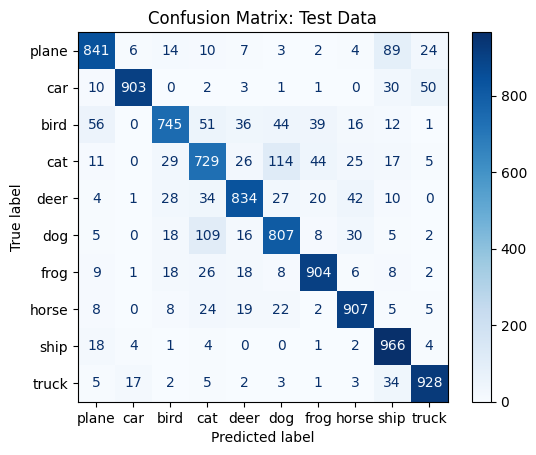

In [66]:
test_accuracy, test_cm = evaluate_best_model(
    model=model, 
    test_loader=test_loader, 
    load_path="best_model.pth",
    num_classes=num_classes  
)